# Librerias y Carga de Datos

In [9]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder

El dataset fue previamente convertido de formato .pkl a .csv en un entorno local de visual studio. El nuevo archivo en .csv se encuentra en Kaggle de manera pública así que no debería presentar ningún error a la hora de cargar el dataset para su uso.

In [10]:
def load_dataset(data_path="/kaggle/input/datasetchec/Dataset_Full_Enriched.csv"):
    """
    Carga el dataset completo de activos eléctricos en CSV.
    """
    print("\n" + "="*80)
    print("LOADING POWERGRID DATASET")
    print("="*80)

    try:
        df = pd.read_csv(data_path, low_memory = False)
        print("Dataset loaded successfully")
        print("Rows:", df.shape[0])
        print("Columns:", df.shape[1])
    except FileNotFoundError:
        print("CSV file not found at:", data_path)
        return None
    except Exception as e:
        print("Error loading the dataset:", e)
        return None

    return df

def encode_categorical(df):
    """
    Codifica columnas categóricas usando LabelEncoder.
    Retorna df codificado, mappings y encoders.
    """
    df = df.copy(deep= True)

    categorical_cols = ['TIPO','COD_CAUSA','MATERIAL_F','AISLAMIENTO_F','G_N',
        'TIPO_TAXONOMIA','CLASE']

    mappings = {}
    encoders = {}

    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = df[col].fillna('NA').astype(str)
            df[col] = le.fit_transform(df[col])
            encoders[col] = le
            mappings[col] = dict(zip(le.classes_, range(len(le.classes_))))

    return df, mappings, encoders

def fix_numeric_columns(df):
    numeric_cols = [
        'CALIBRE_F',
        'CALIBRE_NEUTRO',
        'ALTURA',
        'CANTIDAD_TIERRA',
        'LONG_CRUCETA'
    ]

    for col in numeric_cols:
        if col in df.columns:
            # Convierte a numérico, convirtiendo errores a NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')

            median_val = df[col].median()
            df.fillna({col: median_val}, inplace=True)

    return df

def eliminar_outliers_iqr(df, col="UITI", factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

def dataset_cleaning(df):
    """
    Limpieza del dataset y separación de variables.
    """
    df = df.copy()

    vis_suffixes = [f"vis_{i}" for i in range(25)]
    cols = [c for c in df.columns if any(c.endswith(suf) for suf in vis_suffixes)]
    df = df.drop(columns=cols, errors='ignore')

    # columnas que NO aportan al modelo
    cols_to_drop = ['CODIGO', 'FECHA','FECHA_OPERACION']

    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Eliminar outliers del objetivo UITI usando IQR
    if 'UITI' in df.columns:
        df = eliminar_outliers_iqr(df, col="UITI")

    # Definir objetivo
    target_col = 'UITI'

    # Crear X e Y
    Y = df[[target_col]]
    X = df.drop(columns=[target_col])

    return X, Y

def dataset_technical(df):
    """
    Limpieza del dataset y separación de variables.
    """
    df = df.copy()

    hour_suffixes = [f"_{i}" for i in range(25)]
    cols = [c for c in df.columns if any(c.endswith(suf) for suf in hour_suffixes)]
    df = df.drop(columns=cols, errors='ignore')

    # columnas que NO aportan al modelo
    cols_to_drop = ['CODIGO', 'FECHA','FECHA_OPERACION']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Eliminar outliers del objetivo UITI usando IQR
    if 'UITI' in df.columns:
        df = eliminar_outliers_iqr(df, col="UITI")

    # definir objetivo
    target_col = 'UITI'

    # Crear X e Y
    Y = df[[target_col]]
    X = df.drop(columns=[target_col])

    return X, Y

In [11]:
df = load_dataset()
print(df.columns)


LOADING POWERGRID DATASET
Dataset loaded successfully
Rows: 661811
Columns: 275
Index(['CODIGO', 'TIPO', 'FECHA', 'DURACION', 'UITI', 'COD_CAUSA', 'NFASES',
       'NEUTRO', 'LONGITUD', 'CALIBRE_F',
       ...
       'clouds_15', 'clouds_16', 'clouds_17', 'clouds_18', 'clouds_19',
       'clouds_20', 'clouds_21', 'clouds_22', 'clouds_23', 'clouds_24'],
      dtype='object', length=275)


Las funciones fueron ajustadas después de revisar a fondo el dataset. De esta manera se aseguro de dejar en lo posible solo los datos realmente utiles para el entrenamiento. Además, se hizo un ajuste en el UITI, eliminando los valores atipicos que podian provocar una desviación en el entrenamiento. 

Se realizaron dos dataset de entrenamiento (X, Y) que contiene todas las columnas de datos incluyendo las relacionadas a las variables metereologicas por hora y (X_2, Y_2) que elimina dichas variables. 

De acuerdo con esto, se espera que el entrenamiento con (X, Y) permita obtener mejores resultados.

In [12]:
# Arreglar columnas numéricas que quedaron como object
df = fix_numeric_columns(df)

# Codificar columnas categóricas
df_new, mappings, encoders = encode_categorical(df)

# Limpiar dataset y separar X, Y
X, Y = dataset_cleaning(df_new)
X_2, Y_2 = dataset_technical(df_new)

# Revisar información final (dataset completo)
print("\n===== FEATURES (X) =====")
print(X.shape)
X.info()

print("\n===== TARGET (Y) =====")
print(Y.shape)
Y.info()

# Revisar información final (dataset sin variables metereologicas)
print("\n====== DATASET SIN VARIABLES METEREOLÓGICAS ======")
print("\n===== FEATURES (X_2) =====")
print(X_2.shape)
X_2.info()

print("\n==== TARGET (Y_2) =====")
print(Y_2.shape)
Y_2.info()


===== FEATURES (X) =====
(563691, 246)
<class 'pandas.core.frame.DataFrame'>
Index: 563691 entries, 0 to 661810
Columns: 246 entries, TIPO to clouds_24
dtypes: float64(235), int64(11)
memory usage: 1.0 GB

===== TARGET (Y) =====
(563691, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 563691 entries, 0 to 661810
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   UITI    563691 non-null  float64
dtypes: float64(1)
memory usage: 8.6 MB

====== DATASET SIN VARIABLES METEREOLÓGICAS ======

===== FEATURES (X_2) =====
(563691, 21)
<class 'pandas.core.frame.DataFrame'>
Index: 563691 entries, 0 to 661810
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TIPO             563691 non-null  int64  
 1   DURACION         563691 non-null  float64
 2   COD_CAUSA        563691 non-null  int64  
 3   NFASES           563691 non-null  int64  
 4   NEUTRO       

# Analisis Exploratorio

Este analisis exploratorio contiene la visualización de las variables después de la limpieza y ajuste del dataset. Además de algunas relaciones por medio de mapas de calor y color para entender a mayor profundidad el comportamiento del dataset.

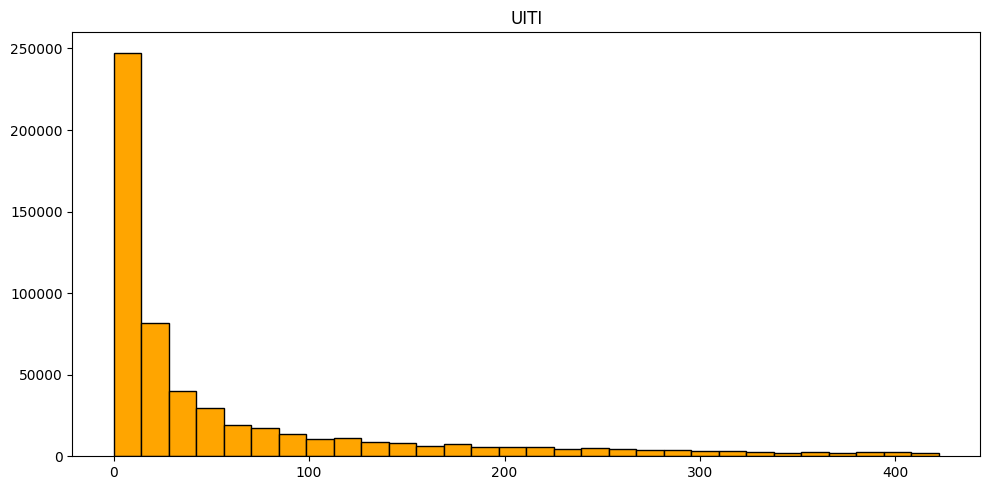

In [5]:
Y.hist(bins=30, figsize=(10,5), color = 'orange', edgecolor='black', grid=False)
plt.tight_layout()
plt.show()

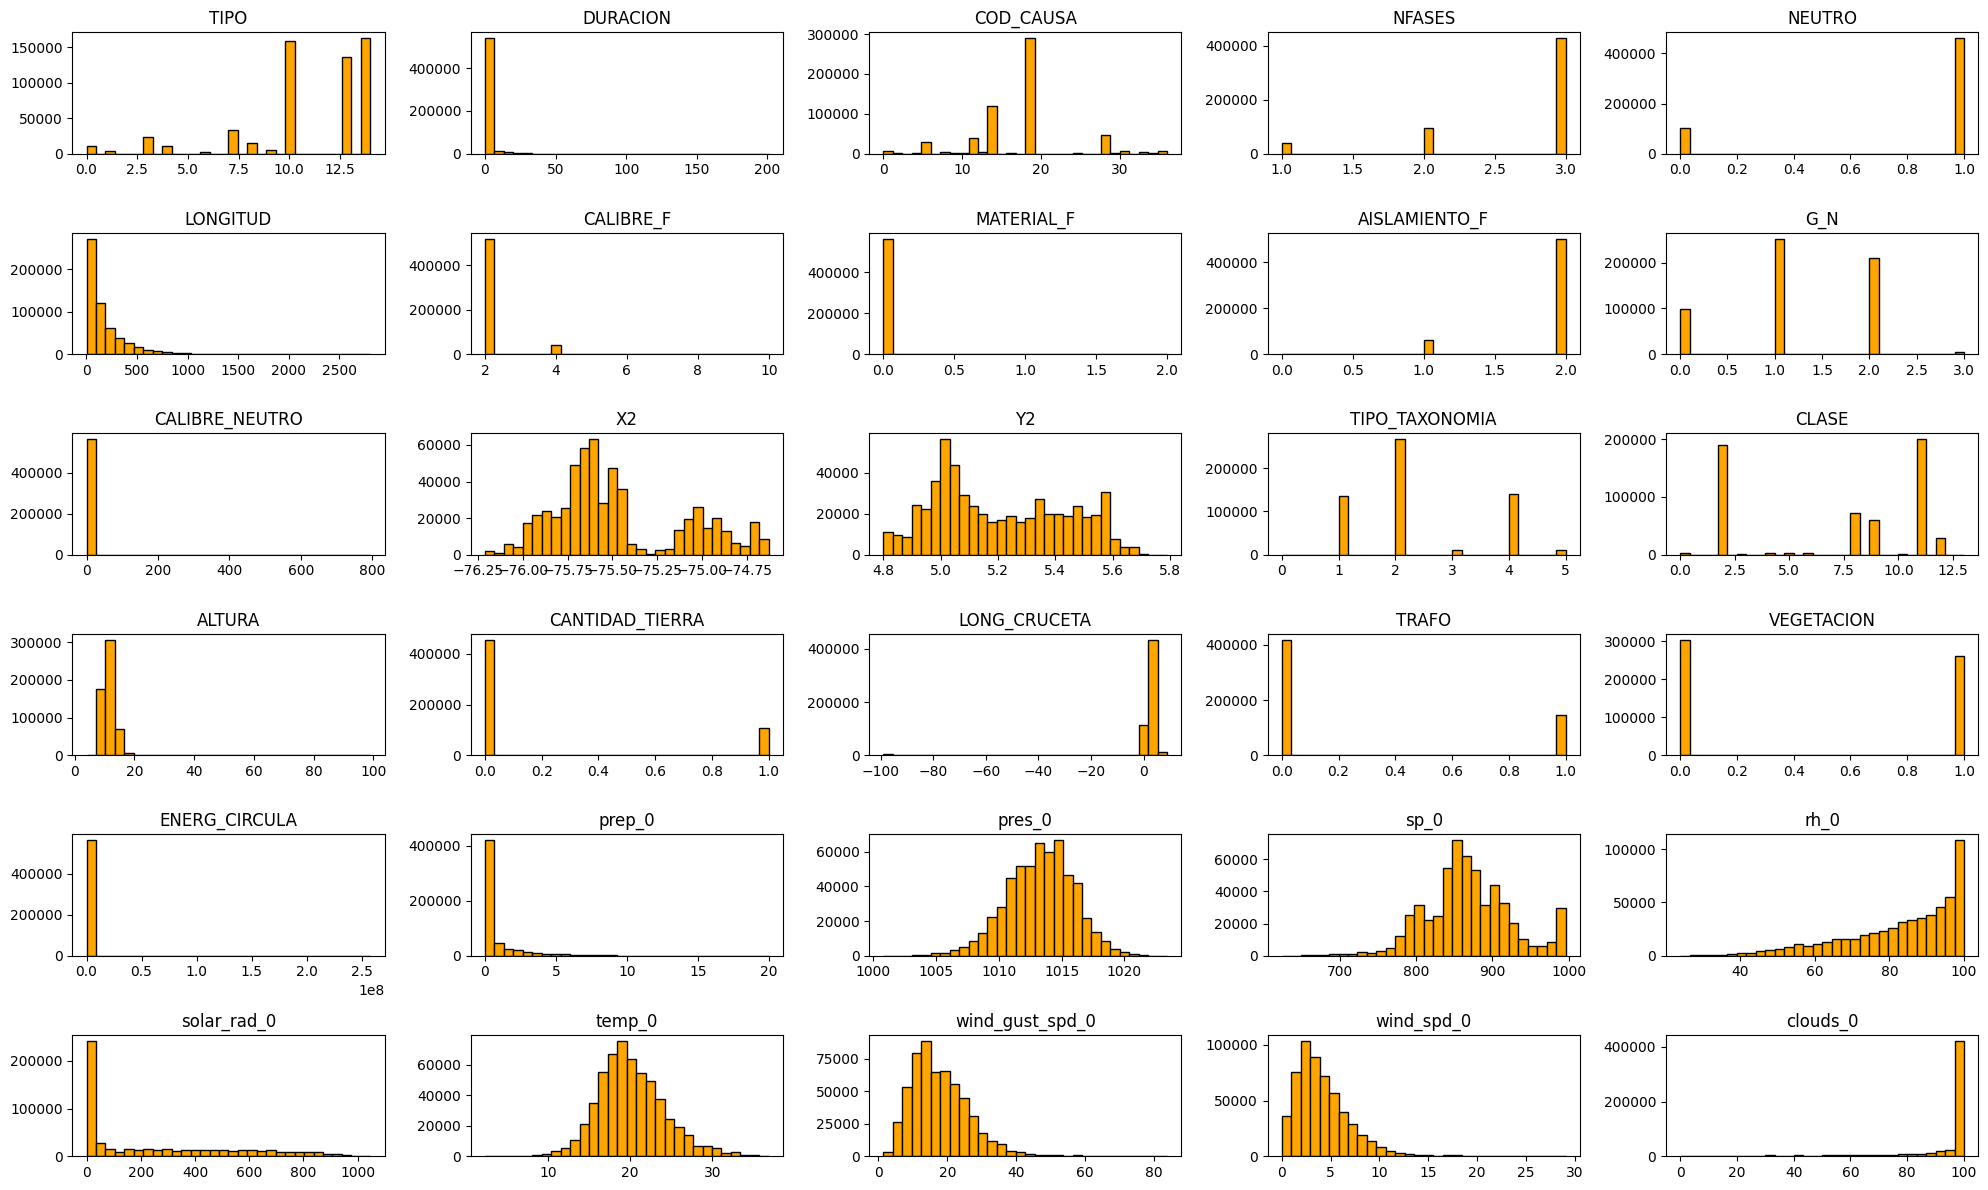

In [6]:
pattern_hourly = re.compile(r".*_(?:[1-9]|1[0-9]|2[0-4])$")
cols = [c for c in X.columns if not pattern_hourly.match(c)]

X[cols].hist(bins=30, figsize=(20,12), color = 'orange', edgecolor='black', grid=False)
plt.tight_layout()
plt.show()

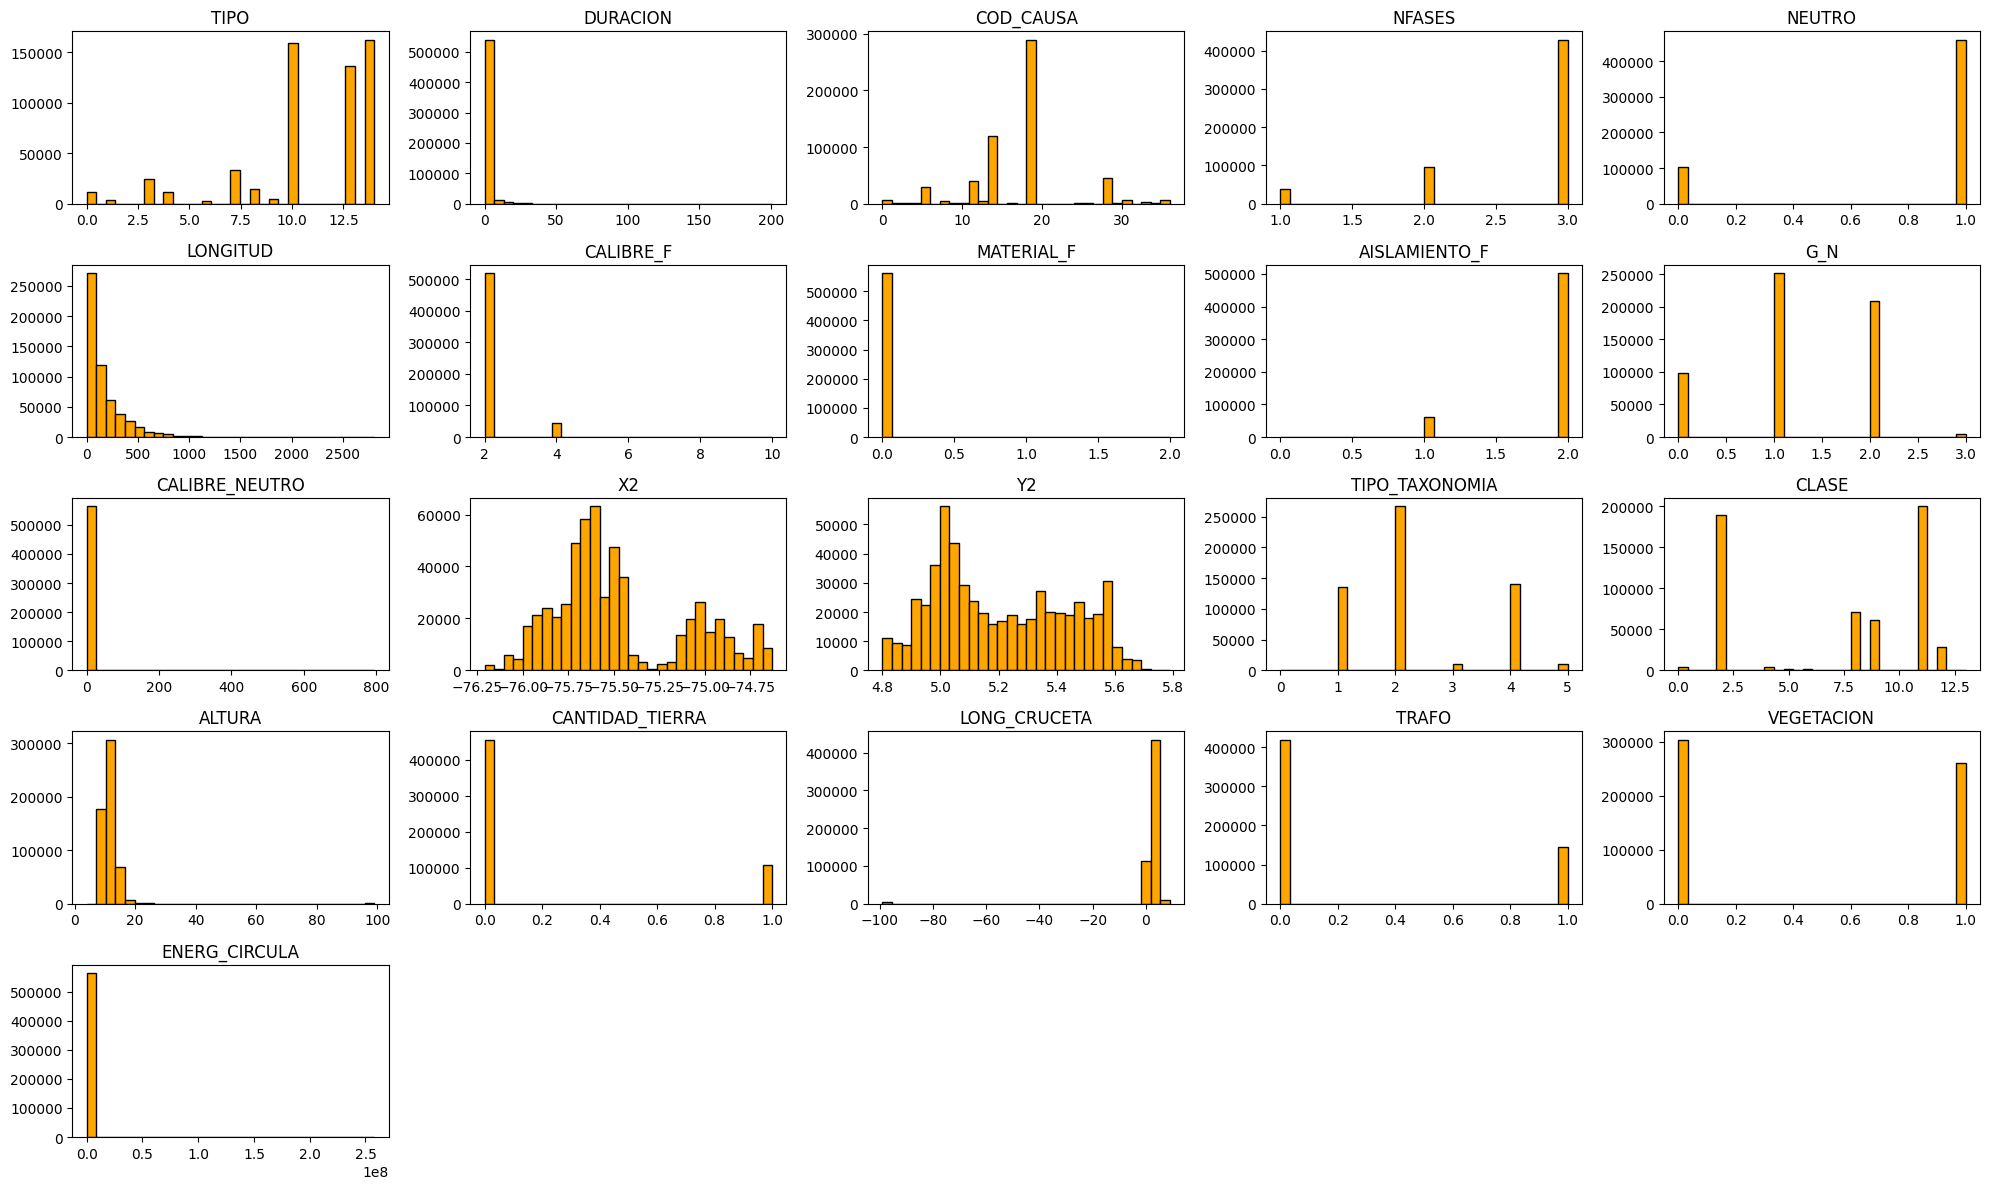

In [13]:
X_2.hist(bins=30, figsize=(20,12), color = 'orange', edgecolor='black', grid=False)
plt.tight_layout()
plt.show()

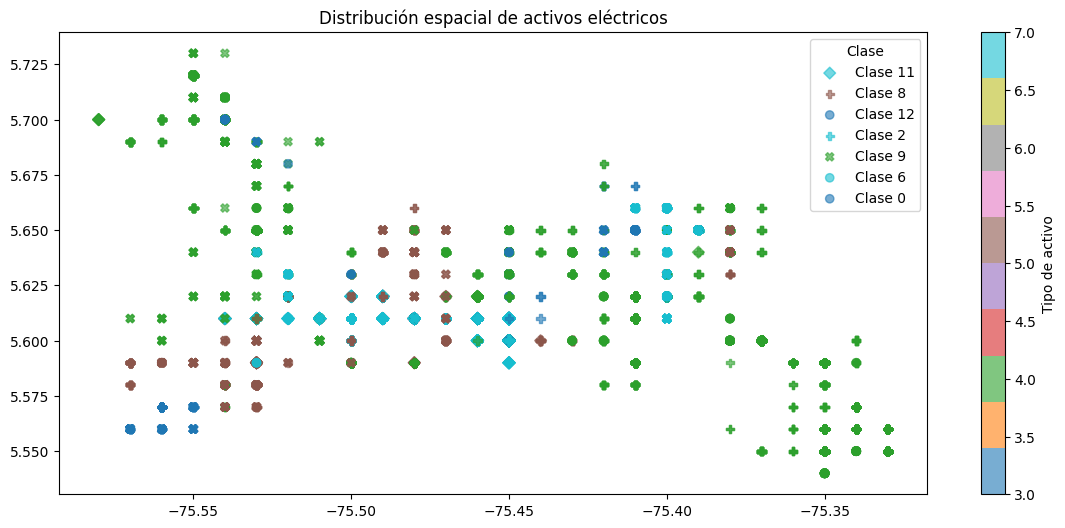

In [14]:
"""
En la siguiente gráfica se visualiza la distribución espacial de una muestra de los
activos eléctricos, utilizando sus coordenadas X2 e Y2. Cada punto representa un activo,
diferenciado por su clase mediante distintos marcadores y por su tipo mediante una escala
de colores. Esta visualización permite identificar cómo se agrupan o dispersan los
activos en el territorio, lo cual es relevante para el análisis de patrones operativos,
planificación de mantenimiento y evaluación de la infraestructura eléctrica.

"""
subset = X.iloc[0:5000]
markers = ["o", "^", "P", "X", "s", "D"]

plt.figure(figsize=(14,6))

for cls_val in subset['CLASE'].unique():
    role_subset = subset[subset['CLASE'] == cls_val]

    plt.scatter(
        role_subset['X2'],
        role_subset['Y2'],
        c=role_subset['TIPO'],
        cmap='tab10',
        marker=markers[cls_val % len(markers)],
        alpha=0.6,
        label=f"Clase {cls_val}"
    )

plt.colorbar(label="Tipo de activo")
plt.legend(title="Clase")
plt.title("Distribución espacial de activos eléctricos")
plt.show()

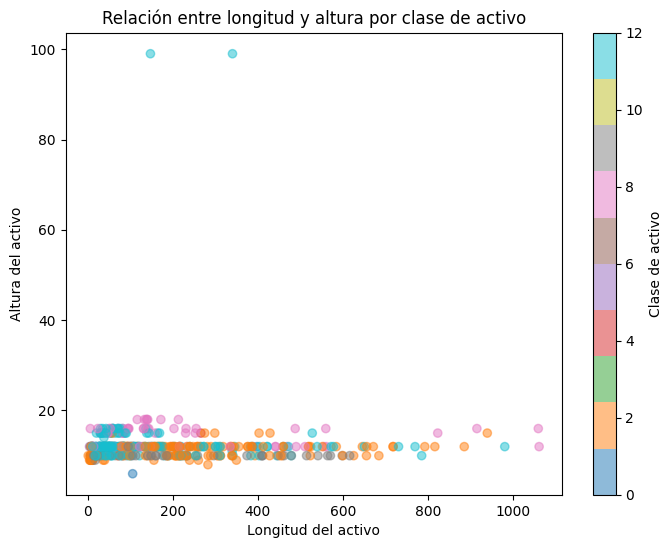

In [15]:
"""
La siguiente gráfica compara la longitud y la altura de distintos activos eléctricos,
diferenciados por su clase. Esto permite identificar variaciones estructurales relevantes
que pueden influir en su comportamiento o nivel de riesgo.

"""
subset = X.sample(500)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    subset['LONGITUD'],
    subset['ALTURA'],
    c=subset['CLASE'],
    cmap='tab10',
    alpha=0.5
)

cbar = plt.colorbar(sc)
cbar.set_label("Clase de activo")

plt.xlabel("Longitud del activo")
plt.ylabel("Altura del activo")
plt.title("Relación entre longitud y altura por clase de activo")
plt.show()

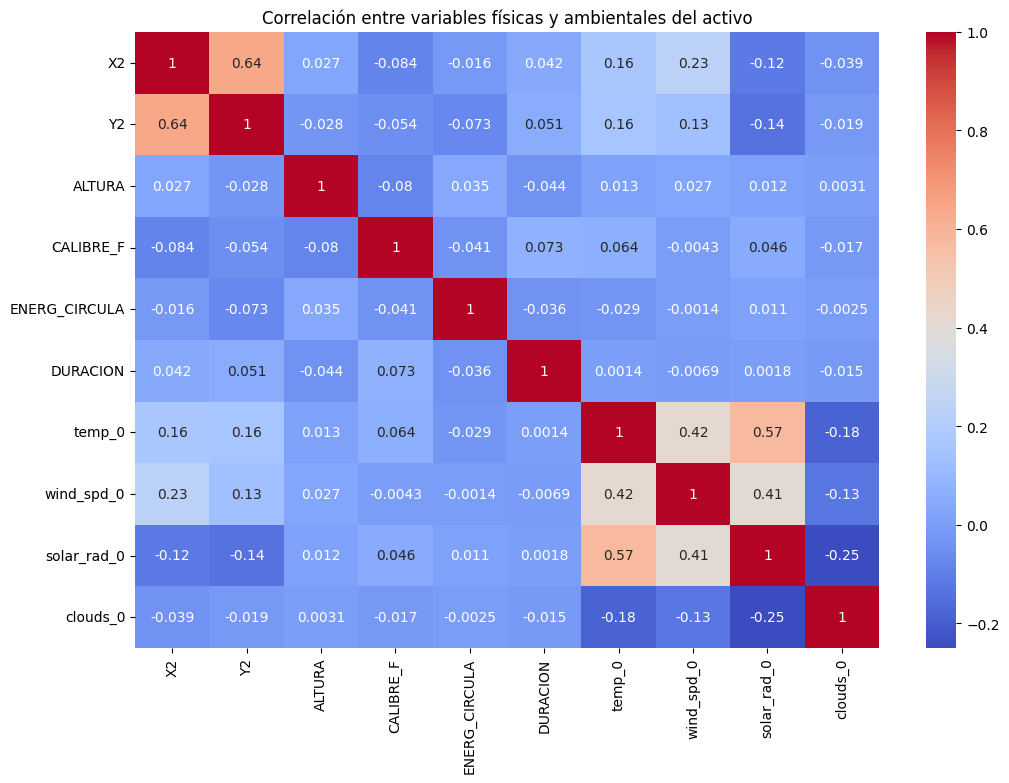

In [16]:
"""
El siguiente cuadro muestra la correlación entre variables físicas del activo
(como su posición geográfica, altura y características estructurales) junto con
variables ambientales instantáneas como temperatura, viento, humedad y radiación solar.
Esta visualización permite identificar qué factores podrían estar relacionados con el
comportamiento y las fallas de los activos eléctricos.

"""
vars_corr = [
    'X2', 'Y2',           # posición
    'ALTURA', 'CALIBRE_F',  # físicas / estructurales
    'ENERG_CIRCULA', 'DURACION',            # operativas
    'temp_0', 'wind_spd_0',  # meteorología
    'solar_rad_0', 'clouds_0']

corr = X[vars_corr].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlación entre variables físicas y ambientales del activo")
plt.show()

# Modelo (TabNet)

Se realizan dos modelos de entrenamiento. Como se menciona anteriormente, uno contiene el dataset completo (despúes del ajuste) y el otro es sin variables metereologicas. Para ambos se realiza el mismo proceso: 

- Optuna para encontrar los mejores hiperparámetros de entrenamiento.
- Los mejores hiperparámetros se usan para obtener el modelo final.
- Este modelo final se descarga para ser usado en la segunda parte de este proyecto (Agente RAG).
- Se calculan los errores para cada modelo (MSE, MAE, R2).

In [17]:
!pip install pytorch-tabnet
clear_output()

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

def error_calculation(pred, real):
  """
  Esta función calcula los diferentes tipos de errores
  sobre la predicción de los modelos en base a los datos
  de testeo.
  """
  mse = mean_squared_error(real, pred)
  mae = mean_absolute_error(real, pred)
  r2 = r2_score(real, pred)
  mape = mean_absolute_percentage_error(real, pred)
  errores = {'mse':mse, 'mae':mae, 'r2':r2, 'mape':mape}
  return errores
clear_output()

## Sin variables metereológicas

In [10]:
# Dataset sin variables metereológicas
X_numpy = X_2.values
Y_numpy = Y_2.values

# Partición de los datos del dataset arreglado y filtrado
X_train_val, X_test, y_train_val, y_test = train_test_split(
  X_numpy, Y_numpy, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
  X_train_val, y_train_val, test_size=0.25, random_state=42)

In [11]:
# Tamaño de los sets
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (338214, 21)
Validation: (112738, 21)
Test: (112739, 21)


In [12]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

import optuna

def objective(trial):

    # Hyperparameters to tune
    n_d = trial.suggest_int("n_d", 8, 64)
    n_a = trial.suggest_int("n_a", 8, 64)
    n_steps = trial.suggest_int("n_steps", 2, 10)
    gamma = trial.suggest_float("gamma", 1.0, 1.5)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_params=dict(lr=lr),
        device_name="cuda"
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['mae'],
        max_epochs=100,
        patience = 20,
        batch_size=trial.suggest_categorical("batch_size", [256, 512, 1024]),
        virtual_batch_size=128,
        drop_last=False,
    )

    # Predict
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    # Verlo durante el tuning
    trial.set_user_attr("r2_score", r2)

    # Return loss for Optuna to minimize
    return mae

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best params:", study.best_trial.params)

In [13]:
best_params = {'n_d': 28, 'n_a': 49, 'n_steps': 2, 'gamma': 1.094361651713903, 'lambda_sparse': 0.0005120156277029637, 'lr': 0.0034142006686731685, 'batch_size': 1024}
best_model = TabNetRegressor(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_params=dict(lr=best_params["lr"]),
    device_name="cuda"
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['mae'],
    max_epochs=100,
    patience=30,
    batch_size=best_params["batch_size"],
    virtual_batch_size=128,
    drop_last=False,
)

In [ ]:
best_model.save_model("best_tabnet_model")

In [ ]:
y_pred = best_model.predict(X_test)
errores = error_calculation(y_test, y_pred)
for k, v in errores.items():
    print(f"{k}: {v:.4f}")

## Con variables metereológicas

In [15]:
# Dataset con variables metereológicas
X_full = X.values
Y_full = Y.values

# Partición de los datos del dataset arreglado y filtrado
Xfull_train_val, Xfull_test, yfull_train_val, yfull_test = train_test_split(
  X_full, Y_full, test_size=0.2, random_state=42)

Xfull_train, Xfull_val, yfull_train, yfull_val = train_test_split(
  Xfull_train_val, yfull_train_val, test_size=0.25, random_state=42)

In [16]:
# Tamaño de los sets
print("Train:", Xfull_train.shape)
print("Validation:", Xfull_val.shape)
print("Test:", Xfull_test.shape)

Train: (338214, 246)
Validation: (112738, 246)
Test: (112739, 246)


In [17]:
def objective(trial):

    # Hyperparameters to tune
    n_d = trial.suggest_int("n_d", 32, 128)
    n_a = trial.suggest_int("n_a", 32, 128)
    n_steps = trial.suggest_int("n_steps", 3, 12)
    gamma = trial.suggest_float("gamma", 1.0, 2.5)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-2, log=True)
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)

    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_params=dict(lr=lr),
        device_name="cuda"
    )

    model.fit(
        Xfull_train, yfull_train,
        eval_set=[(Xfull_val, yfull_val)],
        eval_metric=['mae'],
        max_epochs=100,
        patience = 30,
        batch_size=trial.suggest_categorical("batch_size", [512, 1024, 2048]),
        virtual_batch_size=128,
        drop_last=False,
    )

    # Predict
    preds = model.predict(Xfull_test)

    mae = mean_absolute_error(yfull_test, preds)
    r2 = r2_score(y_test, preds)

    # Verlo durante el tuning
    trial.set_user_attr("r2_score", r2)

    # Return loss for Optuna to minimize
    return r2

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best params:", study.best_trial.params)

In [18]:
best_params = {'n_d': 124, 'n_a': 61, 'n_steps': 6, 'gamma': 1.9123521598772562, 'lambda_sparse': 0.0039030852717804403, 'lr': 0.00022921053095200652, 'batch_size': 512}
best_fullmodel = TabNetRegressor(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_params=dict(lr=best_params["lr"]),
    device_name="auto"
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [19]:
best_fullmodel.fit(
    Xfull_train, yfull_train,
    eval_set=[(Xfull_val, yfull_val)],
    eval_metric=['mae'],
    max_epochs=100,
    patience=30,
    batch_size=best_params["batch_size"],
    virtual_batch_size=128,
    drop_last=False,
)

epoch 0  | loss: 10378.71235| val_0_mae: 54.66933|  0:00:43s
epoch 1  | loss: 9027.57888| val_0_mae: 56.65993|  0:01:27s
epoch 2  | loss: 8396.44711| val_0_mae: 59.9361 |  0:02:10s
epoch 3  | loss: 8118.9772| val_0_mae: 61.35211|  0:02:54s
epoch 4  | loss: 7945.82482| val_0_mae: 61.36094|  0:03:39s
epoch 5  | loss: 7754.93208| val_0_mae: 60.90571|  0:04:23s
epoch 6  | loss: 7596.60365| val_0_mae: 60.31611|  0:05:06s
epoch 7  | loss: 7487.09616| val_0_mae: 59.72102|  0:05:50s
epoch 8  | loss: 7378.11112| val_0_mae: 59.16268|  0:06:34s
epoch 9  | loss: 7302.91953| val_0_mae: 59.32671|  0:07:18s
epoch 10 | loss: 7210.92516| val_0_mae: 58.82966|  0:08:02s
epoch 11 | loss: 7155.11488| val_0_mae: 58.70524|  0:08:46s
epoch 12 | loss: 7088.21603| val_0_mae: 58.88901|  0:09:30s
epoch 13 | loss: 7022.07407| val_0_mae: 58.46611|  0:10:14s
epoch 14 | loss: 6969.62857| val_0_mae: 58.5669 |  0:10:57s
epoch 15 | loss: 6890.0014| val_0_mae: 57.92084|  0:11:41s
epoch 16 | loss: 6874.60407| val_0_mae: 5

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [21]:
best_fullmodel.save_model("best_tabnet_fullmodel")

Successfully saved model at best_tabnet_fullmodel.zip


'best_tabnet_fullmodel.zip'

In [26]:
yfull_pred = best_fullmodel.predict(Xfull_test)
errores_full = error_calculation(yfull_pred, yfull_test)
for k, v in errores_full.items():
    print(f"{k}: {v:.4f}")

mse: 9611.5419
mae: 54.5387
r2: -0.2095
mape: 10.1402


# Mejor modelo reconstruido

In [19]:
import json
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

# === 1. Load parameters ===
with open("/kaggle/input/best-full-model/keras/default/1/model_params.json", "r") as f:
    saved = json.load(f)

params = saved["init_params"]

# === 2. Recreate model architecture ===
model = TabNetRegressor(
    input_dim=params["input_dim"],
    output_dim=params["output_dim"],
    n_d=params["n_d"],
    n_a=params["n_a"],
    n_steps=params["n_steps"],
    gamma=params["gamma"],
    lambda_sparse=params["lambda_sparse"],
    momentum=params["momentum"],
    mask_type=params["mask_type"],
    n_shared=params["n_shared"],
    n_independent=params["n_independent"],
    clip_value=params["clip_value"],
    optimizer_params=params["optimizer_params"],
    scheduler_params=params["scheduler_params"],
    scheduler_fn=params["scheduler_fn"],
    seed=params["seed"],
    verbose=params["verbose"],
    device_name=params["device_name"]
)

# === 3. Load raw PyTorch weights ===
model._set_network()
state_dict = torch.load("/kaggle/input/best-full-model/keras/default/1/network.pt", map_location="cpu")
model.network.load_state_dict(state_dict)

print("Model successfully reconstructed and weights loaded!")

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Model successfully reconstructed and weights loaded!


# Modelo RAG

In [21]:
!pip -q install -U "langchain==0.2.16" "langchain-experimental==0.0.64" langchain-ollama langchain-openai langchain-google-genai google-generativeai chromadb pypdf
clear_output()

In [38]:
!pip install google-generativeai
!pip install sentence-transformers
!pip install faiss-cpu
!pip install python-dotenv   # recomendado para manejar keys
!pip install --quiet pdfplumber
clear_output()

In [28]:
from getpass import getpass
import os

os.environ["GOOGLE_API_KEY"] = getpass("Introduce tu GOOGLE_API_KEY: ")

Introduce tu GOOGLE_API_KEY:  ········


In [29]:
import google.generativeai as genai

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [25]:
import pdfplumber
import re

pdf_path = "/kaggle/input/normas-chec/Redes_aereas_MT.pdf"

def extract_text_from_pdf(path):
    pages = []
    with pdfplumber.open(path) as pdf:
        for p in pdf.pages:
            text = p.extract_text()
            if text:
                pages.append(text)
    return "\n\n".join(pages)

raw_text = extract_text_from_pdf(pdf_path)

# limpieza simple
def clean_text(t):
    t = re.sub(r'\s+\n', '\n', t)  # espacios antes de salto
    t = re.sub(r'\n{2,}', '\n\n', t)  # limitar saltos
    return t.strip()

doc_text = clean_text(raw_text)
len(doc_text), doc_text[:500]

(64229,
 'NORMAS DE DISEÑO Y CONSTRUCCIÓN\nDE REDES DE DISTRIBUCIÓN DE ENERGÍA\nELÉCTRICA\nCapítulo 6. REDES ÁEREAS DE MEDIA\nTENSIÓN\nMA-DI-02-002-001\n29/11/2023 Versión 45.0\nMACROPROCESO: DISTRIBUCIÓN\nPROCESO: INGENIERÍA\nSUBPROCESO: NA\nEste documento es confidencial y para uso exclusivo de CHEC S.A. E.S.P.\nVERSIÓN CAP. Y PÁG.\nFECHA DESCRIPCIÓN DEL CAMBIO MOTIVO\nNO. AFECTADA\nVer Cap. 1 Presentación y Objetivos\nELABORÓ/MODIFICÓ REVISÓ APROBÓ\nCARGO: CET Comité de Normas Comité de Normas\nNOMBRE: CET Comité de No')

In [52]:
import os

def chunk_text(text, chunk_size=800, overlap=200):
    tokens = text.split()  # simple: dividir por palabras
    chunks = []
    i = 0
    while i < len(tokens):
        chunk = tokens[i:i+chunk_size]
        chunks.append(" ".join(chunk))
        i += chunk_size - overlap
    return chunks

def embed(texts):
    embeddings = []
    for t in texts:
        r = genai.embed_content(
            model="models/text-embedding-004",
            content=t
        )
        embeddings.append(r["embedding"])
    return embeddings

def embed_list_with_gemini(texts, model="models/text-embedding-004"):
    vectors = []
    for t in texts:
        out = genai.embed_content(model=model, content=t)
        vectors.append(out["embedding"])
    return np.array(vectors, dtype="float32")

gemini_embeddings = embed_list_with_gemini(chunks)
print(gemini_embeddings.shape)

X = gemini_embeddings.astype("float32")
d = X.shape[1]
index = faiss.IndexFlatL2(d)   # índice sencillo L2
index.add(X)
print("Entradas en FAISS:", index.ntotal)

# Mantén mapping id->texto (lista)
id2text = chunks

(17, 768)
Entradas en FAISS: 17


In [60]:
def build_rag_prompt(question, retrieved, max_context_chars=3000):
    # retrieved: lista de dicts con 'id' y 'text' en orden de relevancia
    # concatenamos hasta max_context_chars para controlar tokens
    context_parts = []
    total = 0
    for r in retrieved:
        part = f"[DOC {r['id']}]\n{r['text']}\n"
        total += len(part)
        if total > max_context_chars:
            break
        context_parts.append(part)
    context = "\n\n---\n\n".join(context_parts)

    prompt = f"""Eres un asistente experto en normas eléctricas. Usa SOLO la información provista en el CONTEXTO para responder la PREGUNTA.
Si la respuesta no está en el contexto, dilo explícitamente y sugiere cómo verificarla (p. ej. buscar en la norma X sección Y).

CONTEXT:
{context}

PREGUNTA:
{question}

RESPUESTA (concisa). Al final añade "CITAS" listando los [DOC id] usados.
"""
    return prompt

def retrieve(query, index, chunks, k=4):
    q_emb = embed([query])[0]
    q_emb = np.array(q_emb).astype("float32").reshape(1, -1)

    distances, ids = index.search(q_emb, k)
    results = [chunks[i] for i in ids[0]]
    return results
    
def build_rag_prompt(question, retrieved_chunks):
    context = "\n\n".join(retrieved_chunks)

    prompt = f"""
Responde la pregunta usando exclusivamente el siguiente contexto:

--- CONTEXTO ---
{context}
----------------

Pregunta: {question}

Responde de forma clara y concisa.
"""
    return prompt

def generate_with_gemini(prompt):
    model = genai.GenerativeModel("models/gemini-2.5-flash")
    response = model.generate_content(prompt)
    return response.text

def rag_answer(question, index, chunks, k=4):
    retrieved = retrieve(question, index, chunks, k=k)
    prompt = build_rag_prompt(question, retrieved)
    answer = generate_with_gemini(prompt)

    return {
        "answer": answer,
        "retrieved": retrieved
    }

In [69]:
result = rag_answer(
    "Cómo se define el calibre del cable de las líneas de distribución a 13.2 kV?",
    index=index,
    chunks=chunks,
    k=4
)

In [70]:
print(result["answer"])

Para las líneas de distribución a 13.2 kV, el calibre mínimo a emplear será ACSR No. 2 AWG en ramales y ACSR No. 2/0 AWG en alimentadores troncales.

Será la CHEC quien establecerá cuáles tramos se consideran ramales o troncales, teniendo en cuenta los planes de expansión y criterios de planeación para el sector. No obstante, el calibre se seleccionará en forma preliminar de acuerdo con los cálculos de diseño.


# Modelo Agentic RAG

In [72]:
def tool_retrieve(query: str, k: int = 4):
    results = retrieve(query, index, chunks, k)
    return {
        "results": results
    }

tools = [
    {
        "function_declarations": [
            {
                "name": "retrieval_tool",
                "description": "Busca información matriz en FAISS",
                "parameters": {
                    "type": "OBJECT",
                    "properties": {
                        "query": {"type": "STRING"},
                        "k": {"type": "NUMBER"}
                    },
                    "required": ["query"]
                },
            }
        ]
    }
]

model = genai.GenerativeModel(
    "models/gemini-2.5-flash",
    tools=tools
)

In [87]:
def agentic_rag(query):

    chat = model.start_chat()   # ES OBLIGATORIO START_CHAT PARA TOOLS

    # 1. Primer mensaje
    response = chat.send_message(query)

    while True:
        parts = response.candidates[0].content.parts
        tool_call = None

         # 1. Buscar si un part contiene un function_call
        for p in parts:
            if hasattr(p, "function_call") and p.function_call is not None:
                tool_call = p.function_call
                break

        # 2. Si hay tool_call → ejecutar herramienta
        if tool_call:
            fn_name = tool_call.name
            args = tool_call.args

            if fn_name == "retrieve":
                retrieved_docs = retrieve(
                    query=args.get("query"),
                    index=index,
                    chunks=chunks,
                    k=args.get("k", 4)
                )
                tool_result = {"docs": retrieved_docs}

            else:
                tool_result = {"error": "unknown tool"}

            # 3. Enviar la respuesta de la tool al modelo
            response = chat.send_message({
                "function_response": {
                    "name": fn_name,
                    "response": tool_result
                }
            })

        else:
            # 4. No hay tool_call → respuesta final
            return response.text

In [ ]:
resp = agentic_rag("¿Cuál es la resistencia máxima de puesta a tierra?")
print(resp)